# Discretization Classification 2.0(Template) - KFold
## Author: Ming

In [1]:
#Import Package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.calibration import CalibratedClassifierCV

#Discretization
from mdlp.discretization import MDLP
from caimcaim import CAIMD
from scorecardbundle.feature_discretization import ChiMerge as cm
from reportgen import preprocessing #Chimerge


from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, confusion_matrix

from threading import Thread, Lock
lock = Lock()

#Import Our Class
%run "TEJ Classification Package.ipynb"

## Import Data

In [2]:
# Load Data
data_name = "Australian_(Dis5Column)Without12"
# data_name = "Australian_Original"

if data_name == "Tsai_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Tsai_BankruptcyData()
elif  data_name == "Germany_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_German_Numeric_CreditData()
elif  data_name == "Germany_700-300(Random)":
    germanData_data_sample, discretize_coloumn = ClassificationDataset().load_German_Numeric_CreditData_Dataframe()
elif  data_name == "Australian_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData()
elif  data_name == "Australian_Normalize(Old)":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData_Normalize()
elif  data_name == "Australian_(Dis5Column)Without12":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData_Different_Continuous_Column()
elif  data_name == "GiveMeSomeCredit":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_GiveMeSomeCredit_CreditData() 
elif  data_name == "Japanese_Credit":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Japanese_CreditData() 
elif  data_name == "Japanese_Bankrupt":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Japanese_BankruptData() 
elif  data_name == "USA_Bankrupt":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_USA_BankruptData() 
    
# # Select Data
# data_list = tsaiData_data
# target_list = tsaiData_target
# discretize_coloumn = continuous_coloumn

# Sampling
# large = germanData_data_sample.loc[germanData_data_sample['default'] == 1]
# small = germanData_data_sample.loc[germanData_data_sample['default'] == 2]
# large = large.sample(n=300)
# germanData_data = pd.concat([large, small])
# germanData_data = germanData_data.sample(frac=1).reset_index(drop=True)
# data_list = germanData_data[[i for i in germanData_data.columns if i != 'default']].values
# target_list = germanData_data[[i for i in germanData_data.columns if i == 'default']].values


# Declare Result List (Alogorithm, fold, ACC, AUC)
evaluation_result_list = []

In [3]:
print ("資料筆數 ::", data_list.shape[0])
print ("特徵數量(不含Target) ::", data_list.shape[1])

資料筆數 :: 690
特徵數量(不含Target) :: 14


In [4]:
unique, counts = np.unique(target_list, return_counts=True)
dict(zip(unique, counts))

{0: 383, 1: 307}

## Select Specific Features to Discretization + Discretization Method (MDLP、CAIM、ChiMerge)

In [5]:
class Discretization:
    def __init__(self, training_data, training_target, discretize_coloumn):
        self.training_data = training_data
        self.training_target = training_target
        self.discretize_coloumn = discretize_coloumn
        self.transformer_MDLP = MDLP()
        self.transformer_CAIMD = CAIMD()
        self.transformer_ChiMerge_SC = cm.ChiMerge(output_dataframe=True)
        self.transformer_ChiMerge_RG = preprocessing.Discretization(method='chimerge')

    def SelectFeatures(self): ##Split Specific to Discretize
        idx_IN_columns = self.discretize_coloumn
        idx_OUT_columns = [i for i in range(np.shape(self.training_data)[1]) if i not in idx_IN_columns]
        selectData_list = self.training_data[:,idx_IN_columns]
        disSelectData_list = self.training_data[:,idx_OUT_columns]
        return selectData_list , disSelectData_list
        
    def MDLP(self,selectData_list): 
        selectDataDiscretiz_list = self.transformer_MDLP.fit_transform(selectData_list, self.training_target)
        return selectDataDiscretiz_list
    
    def MDLP_transform(self,selectData_test_list): 
        selectDataDiscretiz_list = self.transformer_MDLP.transform(selectData_test_list)
        return selectDataDiscretiz_list

    def CAIMD(self,selectData_list):  #CAIMD
        selectDataDiscretiz_list = self.transformer_CAIMD.fit_transform(selectData_list, self.training_target)
        return selectDataDiscretiz_list
    
    def CAIMD_transform(self,selectData_test_list):  #CAIMD
        selectDataDiscretiz_list = self.transformer_CAIMD.transform(selectData_test_list)
        return selectDataDiscretiz_list
    
    def ChiMerge_SC(self,selectData_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_SC.fit_transform(selectData_list, self.training_target.squeeze())
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_SC_transform(self,selectData_test_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_SC.transform(selectData_test_list)
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_RG(self,selectData_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_RG.fit_transform(selectData_list, self.training_target.squeeze())
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_RG_transform(self,selectData_test_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_RG.transform(selectData_test_list)
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def Box_Transform(self,discretize_list):
        for i in discretize_list.columns:
            replace_coloumn = discretize_list[i].unique()
            lst = list(replace_coloumn)
            ip_dict = dict(zip(lst, range(len(lst))))
            discretize_list[i] = discretize_list[i].replace(ip_dict)
        return discretize_list
    
    def MergeFeatures(self,selectDataDiscretiz_list,disSelectData_list):  ## Merge Discretized Data with Original Data
        self.dataDiscretize_list = np.concatenate([selectDataDiscretiz_list,disSelectData_list],axis = 1)
        return self.dataDiscretize_list

## KFoldFuntion

In [6]:
class KFoldFuntion:
    # linear_svc,'linear_svc','baseline', data_list, target_list, fold
    def __init__(self, classifier, classifier_name, method, data_list, target_list, fold, discretize_coloumn):
        self.X = data_list
        self.y = target_list
        self.fold = fold
        self.outcomes_acc = []
        self.outcomes_auc = []
        self.outcomes_typeII = []
        self.outcomes_typeI = []
        self.fold_result_list = []
        self.outcomes_minority = []
        self.outcomes_majority = []
        self.method = method  # (Baseline, MDLP, CAIM)
        self.classifier = classifier
        self.classifier_name = classifier_name
        self.discretize_coloumn = discretize_coloumn
    
    def Classify(self):
        kf = KFold(n_splits=self.fold,random_state=np.random, shuffle=True)
        #kf = StratifiedKFold(n_splits=self.fold)
        #for train_index, test_index in kf.split(self.X,self.y):
        for train_index, test_index in kf.split(self.X):
            X_train, X_test = self.X[train_index], self.X[test_index] #X_train: training data X_test: testing data
            y_train, y_test = self.y[train_index], self.y[test_index] #y_train: training data answer y_test: testing data answer
            
            if self.method == 'Baseline':
                
                # Convert to Dataframe
                X_train_dataframe = pd.DataFrame(X_train)
                X_test_dataframe  = pd.DataFrame(X_test)
                y_train_dataframe = pd.DataFrame(y_train)
                y_test_dataframe  = pd.DataFrame(y_test)
                predictions,proba = self.Classification(X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe)
                self.StoreFoldResult(y_test_dataframe,predictions,proba)
            else:

                # Declare Training Data Discretizer
                discretize_train = Discretization(X_train,y_train,self.discretize_coloumn)

                # Select Discretize Feature (Training Data Continous Feature)
                selectData_list, disSelectData_list  = discretize_train.SelectFeatures() #Devide Discretize Coloumns

                
                
                # Discretize(Train)
                if self.method == 'MDLP':
                    selectDataDiscretiz_list = discretize_train.MDLP(selectData_list)
                elif self.method == 'CAIMD':
                    selectDataDiscretiz_list = discretize_train.CAIMD(selectData_list)
                elif self.method == 'ChiMerge_SC':
                    selectDataDiscretiz_list = discretize_train.ChiMerge_SC(selectData_list)
                elif self.method == 'ChiMerge_RG':
                    selectDataDiscretiz_list = discretize_train.ChiMerge_RG(selectData_list)
                # Merge dis_feature & categeorial_feature
                X_train_dis = discretize_train.MergeFeatures(selectDataDiscretiz_list,disSelectData_list)

                # Declare Testing Data Discretizer
                discretize_test = Discretization(X_test,y_test,discretize_coloumn)

                # Select Discretize Feature (Testing Data Continous Feature)
                selectData_test_list, disSelectData_test_list  = discretize_test.SelectFeatures()

                
                
                # Employ Training Data Cutpoint
                if self.method == 'MDLP':
                    selectDataDiscretiz_test_list = discretize_train.MDLP_transform(selectData_test_list)
                elif self.method == 'CAIMD':
                    selectDataDiscretiz_test_list = discretize_train.CAIMD_transform(selectData_test_list)
                elif self.method == 'ChiMerge_SC':
                    selectDataDiscretiz_test_list = discretize_train.ChiMerge_SC_transform(selectData_test_list)
                elif self.method == 'ChiMerge_RG':
                    selectDataDiscretiz_test_list = discretize_train.ChiMerge_RG_transform(selectData_test_list)
                    
                # Merge dis_feature & categeorial_feature
                X_test_dis = discretize_test.MergeFeatures(selectDataDiscretiz_test_list,disSelectData_test_list)

                # Convert to Dataframe
                X_train_dis_dataframe = pd.DataFrame(X_train_dis)
                X_test_dis_dataframe = pd.DataFrame(X_test_dis)
                y_train_dataframe = pd.DataFrame(y_train)
                y_test_dataframe = pd.DataFrame(y_test)

                # Prediction
                predictions,proba = self.Classification(X_train_dis_dataframe,y_train_dataframe,X_test_dis_dataframe,y_test_dataframe)
                self.StoreFoldResult(y_test_dataframe,predictions,proba)
        return self.PrintTotalResult()   
                      
    def Classification(self,X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe):
        clf = self.classifier
        clf.fit(X_train_dataframe, y_train_dataframe[0].ravel())
        predictions = clf.predict(X_test_dataframe)
        proba = clf.predict_proba(X_test_dataframe)[:, 1]
        return predictions,proba

    
    def StoreFoldResult(self,y_test_dataframe,predictions,proba):
        
        #Accuracy Score
        accuracy = accuracy_score(y_test_dataframe, predictions)
        self.outcomes_acc.append(accuracy)
        
        #AUC Score
        auc = roc_auc_score(y_test_dataframe, proba)
        self.outcomes_auc.append(auc)
        
        #Type II Error
        TN, FP, FN, TP = confusion_matrix(y_test_dataframe, predictions).ravel()
        typeII = FN/(TP+FN)
        typeI = FP/(FP+TN)
        self.outcomes_typeII.append(typeII)
        self.outcomes_typeI.append(typeI)
        
        #Majority, Minority (Count)
        unique, counts = np.unique(y_test_dataframe, return_counts=True)
        dict(zip(unique, counts))
        
        proportion = np.unique(y_test_dataframe, return_counts=True)
        majority_proportion = proportion[1][0]/(self.X.shape[0]/self.fold)
        minority_proportion = proportion[1][1]/(self.X.shape[0]/self.fold)
        self.outcomes_majority.append(proportion[1][0])
        self.outcomes_minority.append(proportion[1][1])

        
        # Plot fold_result_list 
        each_fold_result_list = [accuracy,auc,typeI,typeII,majority_proportion,minority_proportion]
        self.fold_result_list.append(each_fold_result_list)
    
    def PrintTotalResult(self):
        
        mean_outcome_acc = np.mean(self.outcomes_acc)
        print("Mean Accuracy: {0}".format(mean_outcome_acc))
        print("Mean Accuracy"+ str(self.outcomes_acc))
        
        mean_outcome_auc = np.mean(self.outcomes_auc)
        print("Mean Auc: {0}".format(mean_outcome_auc))
        print("Mean Auc"+ str(self.outcomes_auc))
        
        mean_outcomes_typeII = np.mean(self.outcomes_typeII)
        print("Mean TypeII: {0}".format(mean_outcomes_typeII))
        print("Mean TypeII"+ str(self.outcomes_typeII))
        
        mean_outcomes_typeI = np.mean(self.outcomes_typeI)
        print("Mean TypeI: {0}".format(mean_outcomes_typeI))
        print("Mean TypeI"+ str(self.outcomes_typeI))
        
        lock.acquire()
        
        # Print Each Fold Plot
        self.PrintPlotEachFold(self.fold_result_list,"Result")
        
        lock.release()
        
        return mean_outcome_acc, mean_outcome_auc, mean_outcomes_typeI, mean_outcomes_typeII
    
    def PrintPlotEachFold(self,plot_data,metrics_name):
        
        #Trasnfer Type 
        plot_data = np.array(plot_data)
        
        #Set Each Line Data
        plt.plot(plot_data[:,0],label='acc')
        plt.plot(plot_data[:,1],label='auc')
        plt.plot(plot_data[:,2],label='type I')
        plt.plot(plot_data[:,3],label='type II')
        plt.plot(plot_data[:,4],label='maj', marker='o')
        plt.plot(plot_data[:,5],label='min', marker='o')
        
        #Set Graph Information
        title = '{metrics_name} with {fold} folds-{method}-{classifier_name}'.format(
            metrics_name=metrics_name, fold=self.fold,method=self.method,classifier_name=self.classifier_name )
        plt.title(title)
        plt.xlabel('Folds')
        plt.ylabel('percertange')
        plt.legend(loc='upper right')
        plt.show()
    

## Graph

In [7]:
def CompareMethodMeanResult(data_name, clf_name, rounds,result_10times_baseline,result_10times_MDLP,result_10times_CAIM,result_10times_ChiMerge_SC):
    #Labels
    labels = ['ACC', 'AUC', 'TYPEI', 'TYPEII']
    x = np.arange(len(labels))  # the label locations
    width = 0.15  # the width of the bars

    result_10times_baseline_mean = np.around( np.mean(result_10times_baseline, axis=0), decimals=3)
    result_10times_MDLP_mean =  np.around( np.mean(result_10times_MDLP, axis=0), decimals=3)
    result_10times_CAIM_mean =  np.around( np.mean(result_10times_CAIM, axis=0), decimals=3)
    result_10times_ChiMerge_SC_mean =  np.around( np.mean(result_10times_ChiMerge_SC, axis=0), decimals=3)
    #result_10times_ChiMerge_RG_mean =  np.around( np.mean(result_10times_ChiMerge_RG, axis=0), decimals=3)

    fig, ax = plt.subplots(figsize=(15, 10))
    rects1 = ax.bar(x , result_10times_baseline_mean, width, label='Baseline')
    rects2 = ax.bar(x +width, result_10times_MDLP_mean, width, label='MDLP')
    rects3 = ax.bar(x +width*2, result_10times_CAIM_mean, width, label='CAIM')
    rects4 = ax.bar(x +width*3, result_10times_ChiMerge_SC_mean, width, label='ChiMerge_SC')
    #rects5 = ax.bar(x +width*4, result_10times_ChiMerge_RG_mean, width, label='ChiMerge_RG')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    data_name, clf_name, rounds
    title = 'Compare Result-{data_name}-{classifier_name}'.format(data_name=data_name,classifier_name=clf_name)
    ax.set_title(title)
    ax.set_xticks(x+width)
    ax.set_xticklabels(labels)
    ax.legend(bbox_to_anchor=(1, 0.5))

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', size = 12)
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    #autolabel(rects5)
    
    fig.tight_layout()
    file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
    file_name = "results/{title}_{file_timeA}.png".format(file_timeA = file_time, title= title)
    print(title)
    fig.savefig(file_name)
    plt.show()

In [8]:
def ResultEachMethodLineChart(result, method_name,data_name, classifier_name):
    result = np.array(result)
    
    plt.plot(result[:,0], label='Acc', marker='o')
    plt.plot(result[:,1], label='Auc', marker='o')
    plt.plot(result[:,2], label='TypeI', marker='o')
    plt.plot(result[:,3], label='TypeII', marker='o')
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.ylabel('Percertange')
    plt.xlabel('Rounds')
    title = 'Each Rounds-{data_name}-{method_name}-{classifier_name}'.format(data_name=data_name,method_name=method_name,classifier_name=classifier_name)
    plt.title(title)
    
    
    file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
    #plt.savefig('results/{title}_{file_timeA}.png'.format(file_timeA = file_time, title= title, method_name=method_name, classifier_name=classifier_name), bbox_inches='tight')
    plt.show()
    
    plt.close

## Import Classification Package

In [9]:
from sklearn.svm import SVC, LinearSVC , libsvm
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

## Start Classify

## Run 10 Times


程式開始


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarn

Mean Accuracy: 0.7869565217391304
Mean Accuracy[0.717391304347826, 0.7898550724637681, 0.8333333333333334, 0.782608695652174, 0.8115942028985508]
Mean Auc: 0.8983198815594013
Mean Auc[0.8435897435897436, 0.9106243154435926, 0.9269949066213923, 0.8948264849904195, 0.9155639571518588]
Mean TypeII: 0.3719743197964981
Mean TypeII[0.45, 0.45454545454545453, 0.2903225806451613, 0.36065573770491804, 0.30434782608695654]
Mean TypeI: 0.08883765412534952
Mean TypeI[0.15384615384615385, 0.04819277108433735, 0.06578947368421052, 0.1038961038961039, 0.07246376811594203]
Mean Accuracy: 0.855072463768116
Mean Accuracy[0.8260869565217391, 0.8333333333333334, 0.8623188405797102, 0.8478260869565217, 0.9057971014492754]
Mean Auc: 0.9213466735161807
Mean Auc[0.8947811447811448, 0.9044070683414945, 0.9244337979094077, 0.9292652027027027, 0.9538461538461538]
Mean TypeII: 0.14291569086651054
Mean TypeII[0.16666666666666666, 0.19672131147540983, 0.14285714285714285, 0.125, 0.08333333333333333]
Mean TypeI: 0.1

findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans.
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to sil

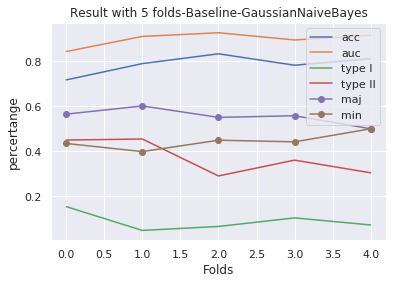

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Mean : [0.78695652 0.89831988 0.08883765 0.37197432]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Mean Accuracy: 0.5579710144927537
Mean Accuracy[0.5507246376811594, 0.572463768115942, 0.47101449275362317, 0.5869565217391305, 0.6086956521739131]
Mean Auc: 0.668360038611804
Mean Auc[0.6844383445945945, 0.6844794549712583, 0.6857744994731295, 0.6831275720164609, 0.6039803220035778]
Mean TypeII: 0.9735891992176194
Mean TypeII[0.96875, 0.9672131147540983, 0.9863013698630136, 0.9649122807017544, 0.9807692307692307]
Mean TypeI: 0.014991938867907862
Mean TypeI[0.0, 0.0, 0.015384615384615385, 0.024691358024691357, 0.03488372093023256]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


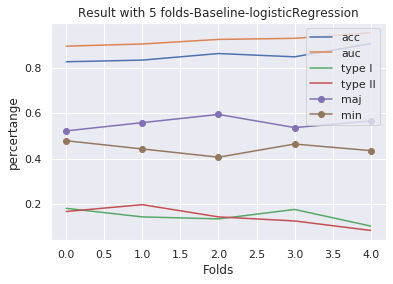

Mean : [0.85507246 0.92134667 0.14715976 0.14291569]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Mean Accuracy: 0.8739130434782609
Mean Accuracy[0.9130434782608695, 0.8840579710144928, 0.8695652173913043, 0.8333333333333334, 0.8695652173913043]
Mean Auc: 0.9364355948047705
Mean Auc[0.9564940577249575, 0.9293913796837773, 0.9634615384615385, 0.9153225806451615, 0.9175084175084175]
Mean TypeII: 0.150640016463446
Mean TypeII[0.08064516129032258, 0.17543859649122806, 0.18333333333333332, 0.1774193548387097, 0.13636363636363635]
Mean TypeI: 0.10776353276353276
Mean TypeI[0.09210526315789473, 0.07407407407407407, 0.08974358974358974, 0.15789473684210525, 0.125]
Mean Accuracy: 0.8565217391304347
Mean Accuracy[0.8695652173913043, 0.8478260869565217, 0.8260869565217391, 0.8768115942028986, 0.8623188405797102]
Mean Auc: 0.9259285542589979
Mean Auc[0.9351890756302521, 0.9323717948717949, 0.9100529100529101, 0.9359579489379961, 0.9160710418020359]
Mean TypeII: 0.20109179562398852
Mean TypeII[0.20588235294117646, 0.16666666666666666, 0.2698412698412698, 0.15254237288135594, 0.21052631578947367

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


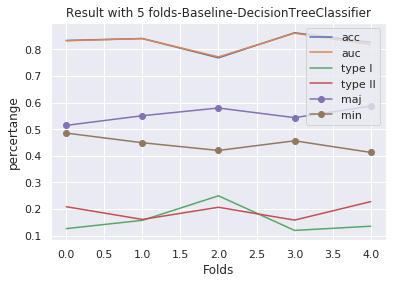

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Mean : [0.82608696 0.82455998 0.15809155 0.19278849]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, incre

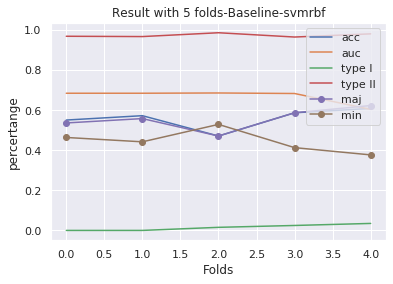

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Mean : [0.55797101 0.66836004 0.01499194 0.9735892 ]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Mean Accuracy: 0.7130434782608697
Mean Accuracy[0.7463768115942029, 0.7681159420289855, 0.6086956521739131, 0.7246376811594203, 0.717391304347826]
Mean Auc: 0.8669081225401201
Mean Auc[0.8863492063492063, 0.9034482758620689, 0.875, 0.7908174211542589, 0.8789257093350661]
Mean TypeII: 0.5550744091868088
Mean TypeII[0.36507936507936506, 0.5, 0.7714285714285715, 0.5423728813559322, 0.5964912280701754]
Mean TypeI: 0.0670355524300672
Mean TypeI[0.16, 0.0375, 0.0, 0.0759493670886076, 0.06172839506172839]


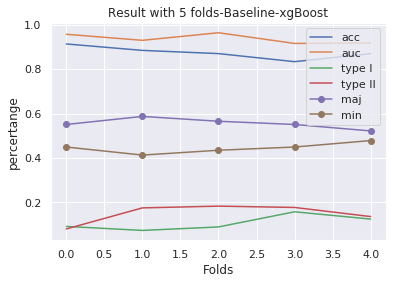

Mean : [0.87391304 0.93643559 0.10776353 0.15064002]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


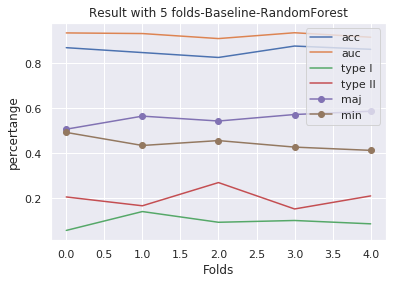

Mean : [0.85652174 0.92592855 0.09583748 0.2010918 ]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


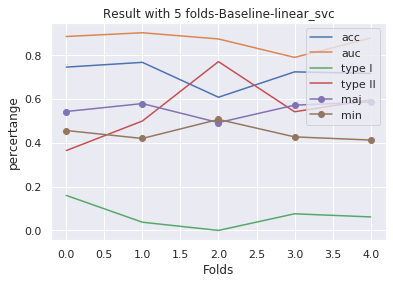

Mean : [0.71304348 0.86690812 0.06703555 0.55507441]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Mean Accuracy: 0.8594202898550722
Mean Accuracy[0.8768115942028986, 0.8188405797101449, 0.855072463768116, 0.8478260869565217, 0.8985507246376812]
Mean Auc: 0.9147012174400084
Mean Auc[0.941358024691358, 0.8735269360269361, 0.9165966386554621, 0.9123767798466593, 0.9296477079796265]
Mean TypeII: 0.18924700150506604
Mean TypeII[0.14814814814814814, 0.21212121212121213, 0.24285714285714285, 0.18181818181818182, 0.16129032258064516]
Mean TypeI: 0.09783999628175091
Mean TypeI[0.10714285714285714, 0.1527777777777778, 0.04411764705882353, 0.13253012048192772, 0.05263157894736842]
Mean Accuracy: 0.8594202898550725
Mean Accuracy[0.8478260869565217, 0.8333333333333334, 0.8478260869565217, 0.855072463768116, 0.9130434782608695]
Mean Auc: 0.9223857358449887
Mean Auc[0.9202037351443123, 0.923611111111111, 0.8994708994708995, 0.9195767195767195, 0.9490662139219016]
Mean TypeII: 0.14016198854908532
Mean TypeII[0.1774193548387097, 0.19696969696969696, 0.16666666666666666, 0.09523809523809523, 0.06451

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


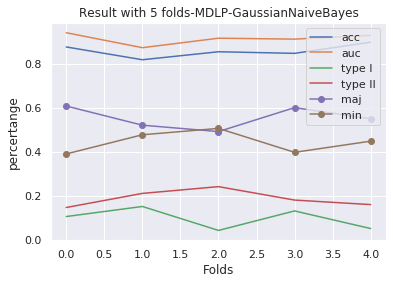

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Mean Accuracy: 0.8144927536231885
Mean Accuracy[0.782608695652174, 0.8043478260869565, 0.7971014492753623, 0.8333333333333334, 0.855072463768116]
Mean Auc: 0.8157837149385149
Mean Auc[0.7788793103448275, 0.8164392462638077, 0.7901709401709403, 0.8379668930390494, 0.8554621848739496]
Mean TypeII: 0.21003576795158088
Mean TypeII[0.22413793103448276, 0.21052631578947367, 0.26666666666666666, 0.1774193548387097, 0.17142857142857143]
Mean TypeI: 0.16541462693939474
Mean TypeI[0.2125, 0.18518518518518517, 0.15384615384615385, 0.15789473684210525, 0.11764705882352941]


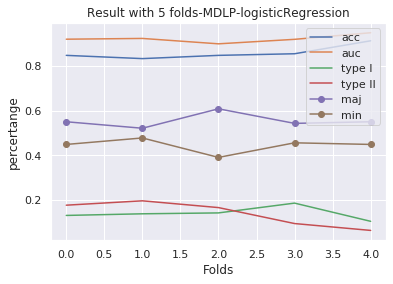

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


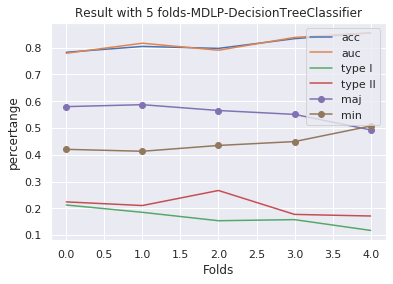

Categorical []
Mean Accuracy: 0.7057971014492754
Mean Accuracy[0.7246376811594203, 0.7028985507246377, 0.644927536231884, 0.7246376811594203, 0.7318840579710145]
Mean Auc: 0.7818397506130081
Mean Auc[0.7664416376306621, 0.801043219076006, 0.755672268907563, 0.7766659569938258, 0.8093756704569834]
Mean TypeII: 0.43285476124320255
Mean TypeII[0.39285714285714285, 0.36065573770491804, 0.5285714285714286, 0.47540983606557374, 0.4067796610169492]
Mean TypeI: 0.1799571730232973
Mean TypeI[0.1951219512195122, 0.24675324675324675, 0.17647058823529413, 0.11688311688311688, 0.16455696202531644]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


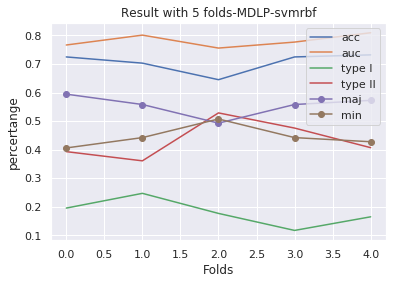

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Mean Accuracy: 0.8565217391304347
Mean Accuracy[0.8405797101449275, 0.8695652173913043, 0.8333333333333334, 0.8695652173913043, 0.8695652173913043]
Mean Auc: 0.9338999845549127
Mean Auc[0.9307004470938898, 0.9509421702404158, 0.9013157894736843, 0.9386752136752137, 0.94786630229136]
Mean TypeII: 0.16043658243060627
Mean TypeII[0.16393442622950818, 0.14035087719298245, 0.14516129032258066, 0.23333333333333334, 0.11940298507462686]
Mean TypeI: 0.13112771879759771
Mean TypeI[0.15584415584415584, 0.12345679012345678, 0.18421052631578946, 0.05128205128205128, 0.14084507042253522]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


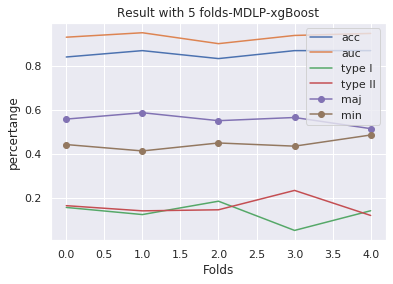

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Mean Accuracy: 0.7289855072463768
Mean Accuracy[0.7753623188405797, 0.7318840579710145, 0.7318840579710145, 0.6666666666666666, 0.7391304347826086]
Mean Auc: 0.7998341809490322
Mean Auc[0.8719158978759923, 0.82086406743941, 0.8260504201680673, 0.6706715297146535, 0.8096689895470383]
Mean TypeII: 0.30926988265971317
Mean TypeII[0.15254237288135594, 0.16923076923076924, 0.5, 0.4745762711864407, 0.25]
Mean TypeI: 0.23472866465393333
Mean TypeI[0.27848101265822783, 0.3561643835616438, 0.04285714285714286, 0.22784810126582278, 0.2682926829268293]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Mean Accuracy: 0.8434782608695652
Mean Accuracy[0.8478260869565217, 0.8768115942028986, 0.8115942028985508, 0.8260869565217391, 0.855072463768116]
Mean Auc: 0.9109360634672962
Mean Auc[0.9113146551724138, 0.9328767123287671, 0.8818972835314092, 0.9007478632478632, 0.9278438030560272]
Mean TypeII: 0.19924702661076413
Mean TypeII[0.1724137931034483, 0.1076923076923077, 0.3064516129032258, 0.2, 0.20967741935483872]
Mean TypeI: 0.12250859630636127
Mean TypeI[0.1375, 0.136986301369863, 0.09210526315789473, 0.15384615384615385, 0.09210526315789473]


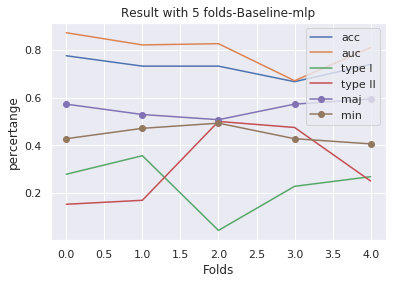

Mean : [0.72898551 0.79983418 0.23472866 0.30926988]


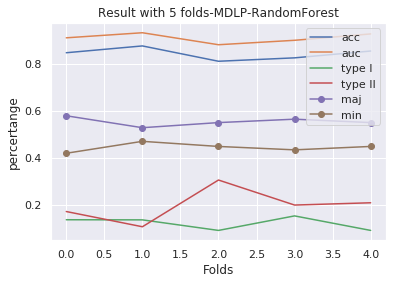

Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, incre

Categorical []
Mean Accuracy: 0.844927536231884
Mean Accuracy[0.855072463768116, 0.8478260869565217, 0.8695652173913043, 0.7971014492753623, 0.855072463768116]
Mean Auc: 0.9208150752565931
Mean Auc[0.9054878048780487, 0.9167622105021784, 0.9487881981032666, 0.9022222222222223, 0.9308149405772496]
Mean TypeII: 0.15209189581539811
Mean TypeII[0.14285714285714285, 0.1836734693877551, 0.1076923076923077, 0.21333333333333335, 0.11290322580645161]
Mean TypeI: 0.1586773355301557
Mean TypeI[0.14634146341463414, 0.1348314606741573, 0.1506849315068493, 0.19047619047619047, 0.17105263157894737]
Categorical []


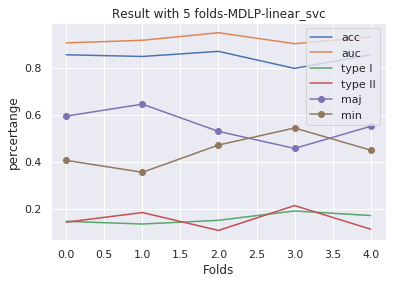

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Categorical []
Categorical []
Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Categorical []
Categorical []
Categorical []
Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anacond

Categorical []
Categorical []
Categorical []
Categorical []
Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Categorical []
Categorical []
Mean Accuracy: 0.8681159420289856
Mean Accuracy[0.8768115942028986, 0.9057971014492754, 0.8623188405797102, 0.8188405797101449, 0.8768115942028986]
Mean Auc: 0.9162885631775033
Mean Auc[0.9455467372134039, 0.9319283456269758, 0.8787050662182048, 0.9018619934282585, 0.9234006734006733]
Mean TypeII: 0.16607073413043563
Mean TypeII[0.2037037037037037, 0.12307692307692308, 0.16417910447761194, 0.12727272727272726, 0.21212121212121213]
Mean TypeI: 0.10222638299954316
Mean TypeI[0.07142857142857142, 0.0684931506849315, 0.11267605633802817, 0.21686746987951808, 0.041666666666666664]


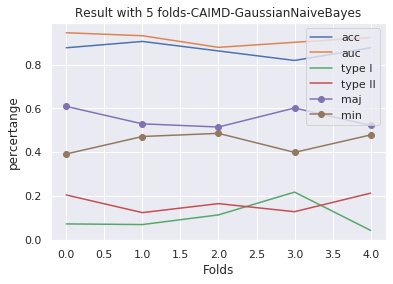

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Mean Accuracy: 0.856521739130435
Mean Accuracy[0.8985507246376812, 0.8333333333333334, 0.855072463768116, 0.8333333333333334, 0.8623188405797102]
Mean Auc: 0.9242694665336207
Mean Auc[0.9537351443123939, 0.9145549057829758, 0.903448275862069, 0.9285563751317175, 0.9210526315789473]
Mean TypeII: 0.13674650917906864
Mean TypeII[0.04838709677419355, 0.08771929824561403, 0.15517241379310345, 0.1643835616438356, 0.22807017543859648]
Mean TypeI: 0.14955278152646573
Mean TypeI[0.14473684210526316, 0.2222222222222222, 0.1375, 0.16923076923076924, 0.07407407407407407]
Categorical []
Mean Accuracy: 0.8144927536231883
Mean Accuracy[0.8260869565217391, 0.8188405797101449, 0.8188405797101449, 0.8115942028985508, 0.7971014492753623]
Mean Auc: 0.8156556980204261
Mean Auc[0.825, 0.8192508710801394, 0.8210559931871408, 0.8165860836661761, 0.7963855421686747]
Mean TypeII: 0.20987856556863022
Mean TypeII[0.23529411764705882, 0.17857142857142858, 0.19672131147540983, 0.23880597014925373, 0.2]
Mean TypeI: 

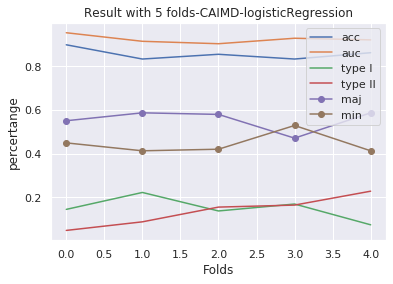

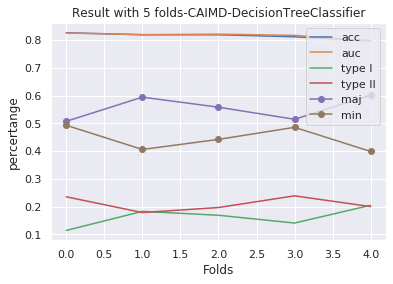

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Mean Accuracy: 0.7159420289855072
Mean Accuracy[0.6666666666666666, 0.7318840579710145, 0.8043478260869565, 0.7246376811594203, 0.6521739130434783]
Mean Auc: 0.7877031632619061
Mean Auc[0.7165948275862069, 0.8026343519494205, 0.8862478777589133, 0.793081494057725, 0.7399572649572649]
Mean TypeII: 0.4278155215196372
Mean TypeII[0.5172413793103449, 0.4153846153846154, 0.3709677419354839, 0.43548387096774194, 0.4]
Mean TypeI: 0.16840940602296045
Mean TypeI[0.2, 0.136986301369863, 0.05263157894736842, 0.14473684210526316, 0.3076923076923077]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


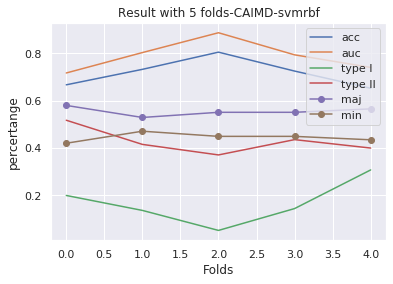

Mean Accuracy: 0.8565217391304347
Mean Accuracy[0.8623188405797102, 0.8478260869565217, 0.8623188405797102, 0.8768115942028986, 0.8333333333333334]
Mean Auc: 0.9350625969511863
Mean Auc[0.9589143960523493, 0.9031612223393045, 0.9434873949579832, 0.9551393728222997, 0.9146105985839948]
Mean TypeII: 0.15502591127715754
Mean TypeII[0.1016949152542373, 0.18461538461538463, 0.17647058823529413, 0.14285714285714285, 0.1694915254237288]
Mean TypeI: 0.13243153856889706
Mean TypeI[0.16455696202531644, 0.1232876712328767, 0.1, 0.10975609756097561, 0.16455696202531644]


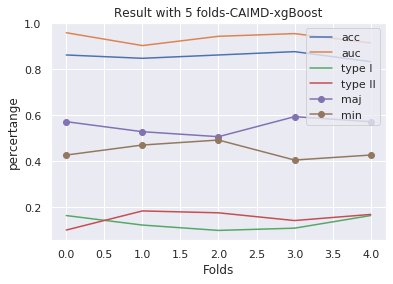

Mean Accuracy: 0.846376811594203
Mean Accuracy[0.8188405797101449, 0.8695652173913043, 0.782608695652174, 0.8405797101449275, 0.9202898550724637]
Mean Auc: 0.9028590819981481
Mean Auc[0.9202960738039048, 0.9044312169312171, 0.8565867003367003, 0.8850295608108107, 0.9479518581081081]
Mean TypeII: 0.1991568224619072
Mean TypeII[0.1864406779661017, 0.2222222222222222, 0.21212121212121213, 0.25, 0.125]
Mean TypeI: 0.1184975210291666
Mean TypeI[0.17721518987341772, 0.07142857142857142, 0.2222222222222222, 0.08108108108108109, 0.04054054054054054]


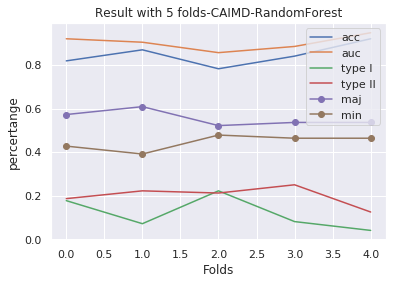

Mean Accuracy: 0.8594202898550725
Mean Accuracy[0.8405797101449275, 0.8985507246376812, 0.8405797101449275, 0.855072463768116, 0.8623188405797102]
Mean Auc: 0.9155196232565691
Mean Auc[0.8693361433087461, 0.9220153340635269, 0.9208005109644454, 0.9126683501683501, 0.9527777777777777]
Mean TypeII: 0.16558408804310445
Mean TypeII[0.12307692307692308, 0.16363636363636364, 0.16393442622950818, 0.22727272727272727, 0.15]
Mean TypeI: 0.12110310285339168
Mean TypeI[0.1917808219178082, 0.060240963855421686, 0.15584415584415584, 0.06944444444444445, 0.1282051282051282]


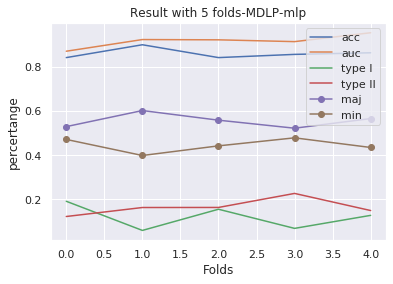

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Mean Accuracy: 0.8463768115942027
Mean Accuracy[0.7898550724637681, 0.8985507246376812, 0.8478260869565217, 0.8768115942028986, 0.8188405797101449]
Mean Auc: 0.9141017084198169
Mean Auc[0.8868783068783068, 0.9306034482758619, 0.9205111544292831, 0.9393939393939393, 0.8931216931216931]
Mean TypeII: 0.15610421036918315
Mean TypeII[0.23809523809523808, 0.1206896551724138, 0.14035087719298245, 0.09090909090909091, 0.19047619047619047]
Mean TypeI: 0.1521543209876543
Mean TypeI[0.18666666666666668, 0.0875, 0.16049382716049382, 0.1527777777777778, 0.17333333333333334]


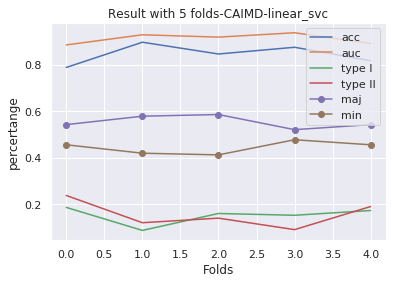

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Mean Accuracy: 0.8710144927536232
Mean Accuracy[0.855072463768116, 0.8623188405797102, 0.9130434782608695, 0.855072463768116, 0.8695652173913043]
Mean Auc: 0.916141611368954
Mean Auc[0.9164562289562289, 0.9072299651567945, 0.9468152196762666, 0.8914355992844365, 0.9187710437710438]
Mean TypeII: 0.15301228622124147
Mean TypeII[0.21212121212121213, 0.16071428571428573, 0.07462686567164178, 0.21153846153846154, 0.10606060606060606]
Mean TypeI: 0.11226100854195571
Mean TypeI[0.08333333333333333, 0.12195121951219512, 0.09859154929577464, 0.10465116279069768, 0.1527777777777778]


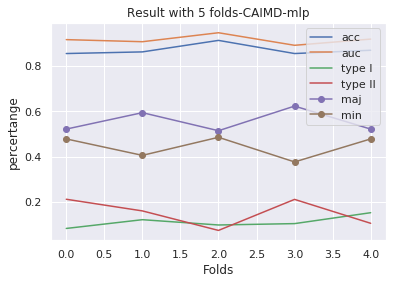

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anacond

Mean Accuracy: 0.827536231884058
Mean Accuracy[0.8478260869565217, 0.8623188405797102, 0.8478260869565217, 0.7391304347826086, 0.8405797101449275]
Mean Auc: 0.9053432322169719
Mean Auc[0.9165437302423605, 0.8953014374597726, 0.9129188712522047, 0.8766806722689076, 0.9252714498616138]
Mean TypeII: 0.16559132513253758
Mean TypeII[0.16923076923076924, 0.11864406779661017, 0.07407407407407407, 0.36764705882352944, 0.09836065573770492]
Mean TypeI: 0.17124021057261912
Mean TypeI[0.136986301369863, 0.1518987341772152, 0.20238095238095238, 0.15714285714285714, 0.2077922077922078]


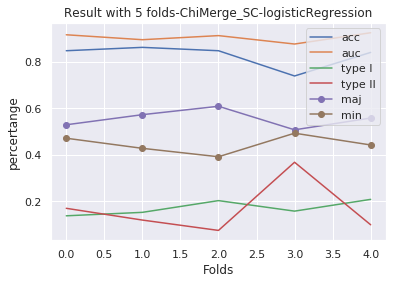

Compare Result-Australian_(Dis5Column)Without12-logisticRegression


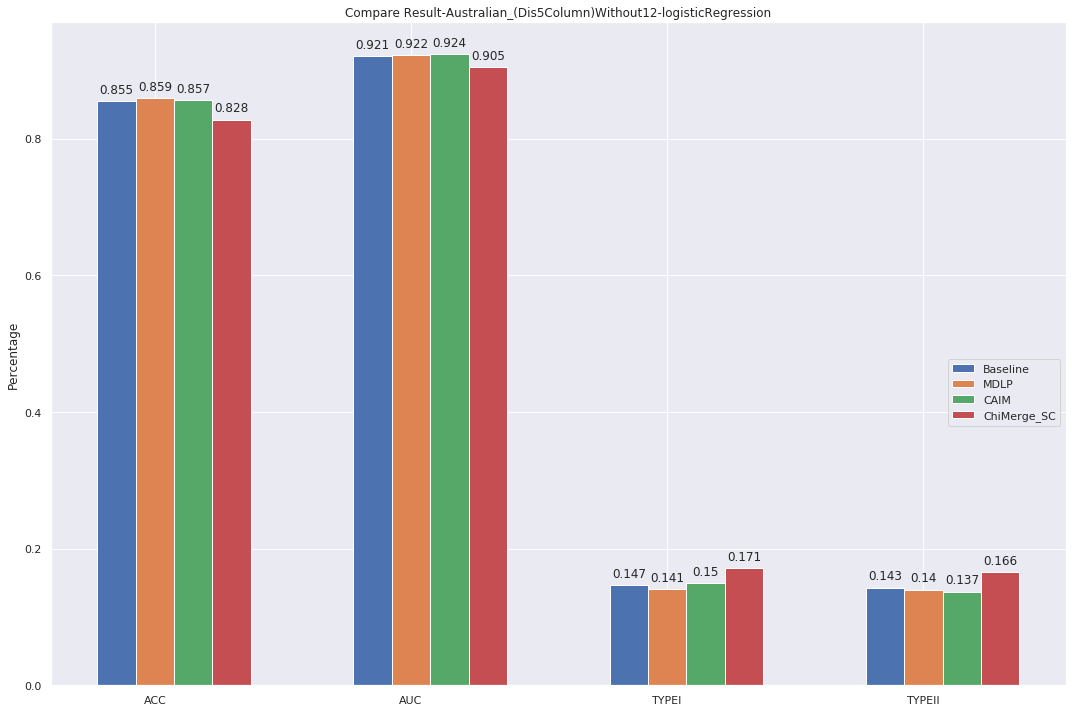

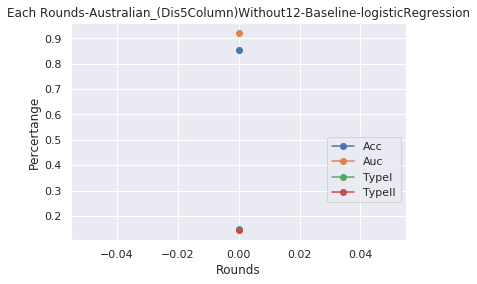

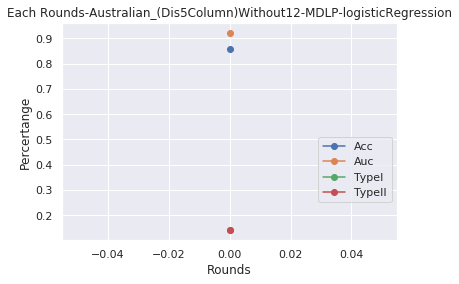

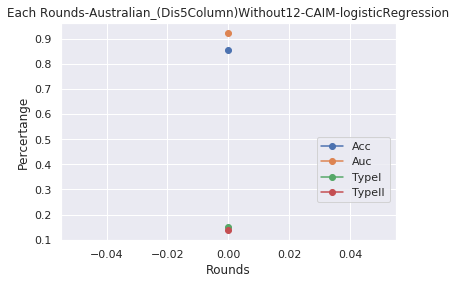

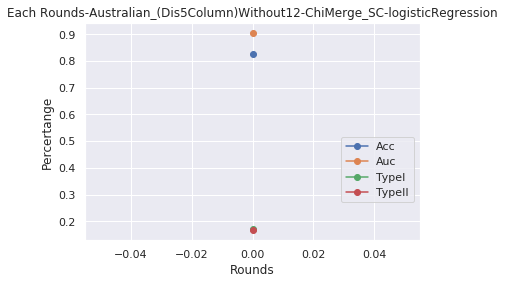

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.86 0.92   0.15    0.14          0.98
MDLP          0.86 0.92   0.14    0.14          7.75
CAIM          0.86 0.92   0.15    0.14         16.22
ChiMerge      0.83 0.91   0.17    0.17        102.75
Mean Accuracy: 0.8202898550724639
Mean Accuracy[0.782608695652174, 0.855072463768116, 0.7898550724637681, 0.8260869565217391, 0.8478260869565217]
Mean Auc: 0.8193853747358549
Mean Auc[0.7810266406757634, 0.8543074324324325, 0.7913851351351351, 0.8287130944331756, 0.8414945710027677]
Mean TypeII: 0.19680548087294522
Mean TypeII[0.22807017543859648, 0.15625, 0.22972972972972974, 0.1568627450980392, 0.21311475409836064]
Mean TypeI: 0.1640631656436254
Mean TypeI[0.20987654320987653, 0.13513513513513514, 0.1875, 0.1839080459770115, 0.1038961038961039]


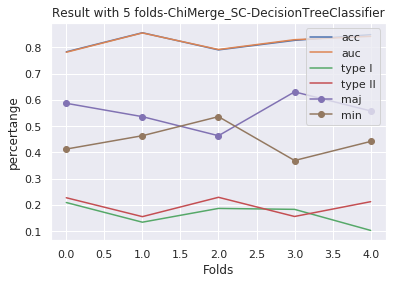

Compare Result-Australian_(Dis5Column)Without12-DecisionTreeClassifier


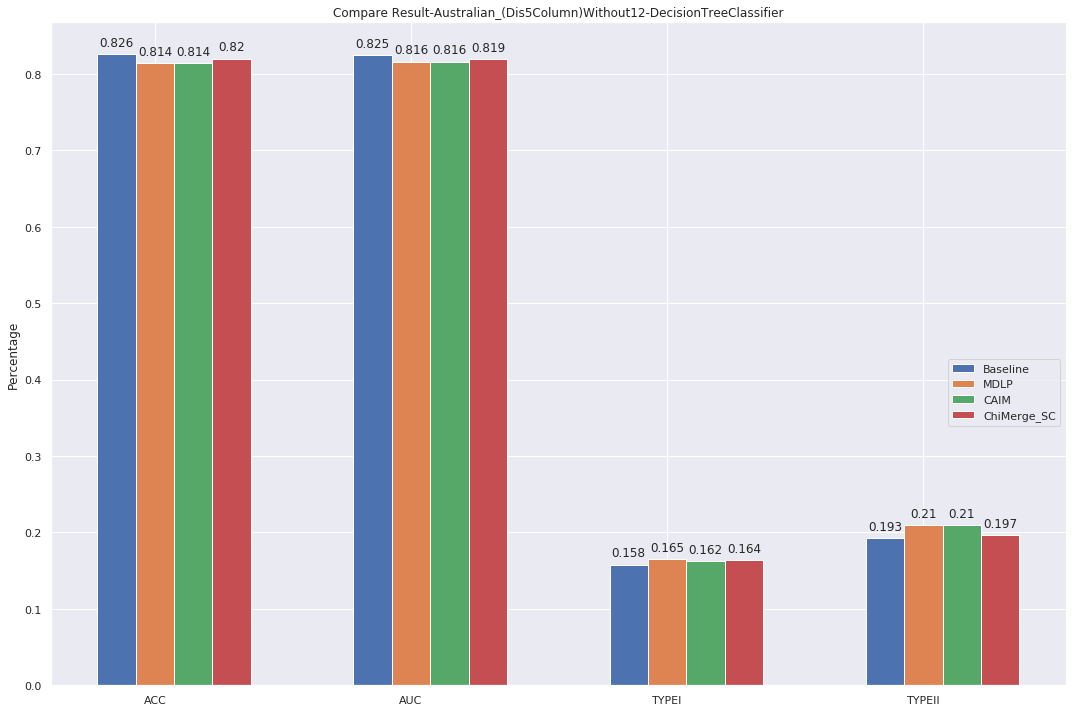

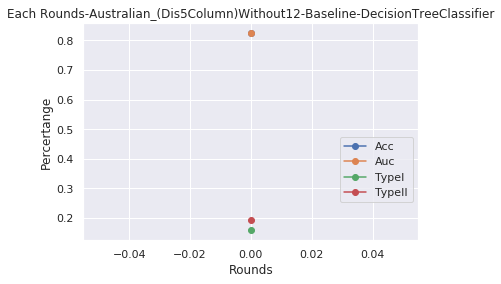

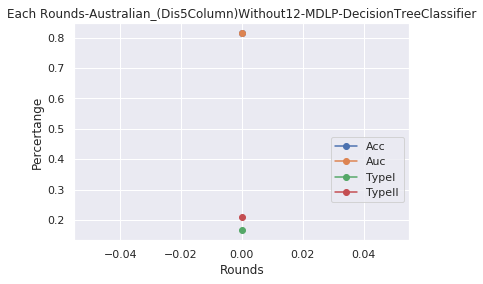

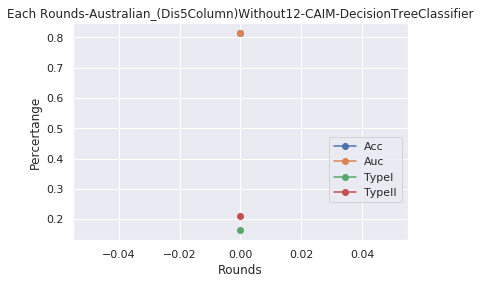

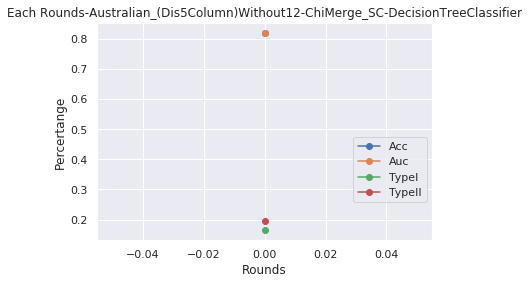

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.83 0.82   0.16    0.19          1.66
MDLP          0.81 0.82   0.17    0.21          8.05
CAIM          0.81 0.82   0.16    0.21         15.98
ChiMerge      0.82 0.82   0.16    0.20        104.62
Mean Accuracy: 0.8347826086956521
Mean Accuracy[0.8478260869565217, 0.8623188405797102, 0.8478260869565217, 0.7391304347826086, 0.8768115942028986]
Mean Auc: 0.8821127410848302
Mean Auc[0.9025191675794085, 0.903342559080264, 0.897142857142857, 0.7964527027027026, 0.9111064189189189]
Mean TypeII: 0.13579082688713834
Mean TypeII[0.10909090909090909, 0.11475409836065574, 0.12698412698412698, 0.171875, 0.15625]
Mean TypeI: 0.18846656263523734
Mean TypeI[0.18072289156626506, 0.15584415584415584, 0.17333333333333334, 0.33783783783783783, 0.0945945945945946]


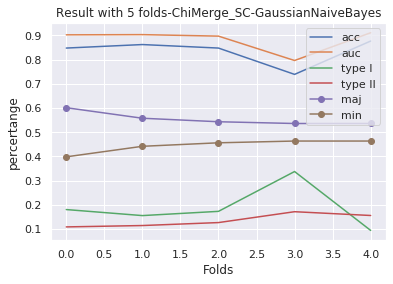

Compare Result-Australian_(Dis5Column)Without12-GaussianNaiveBayes


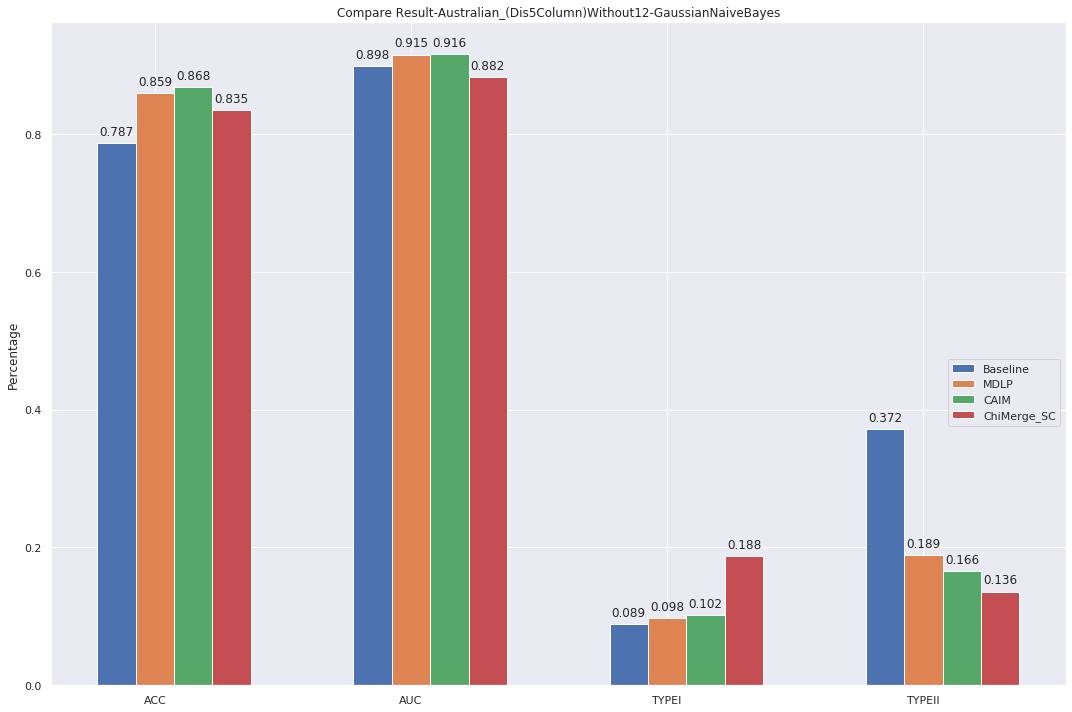

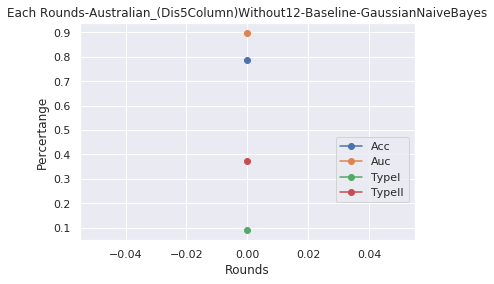

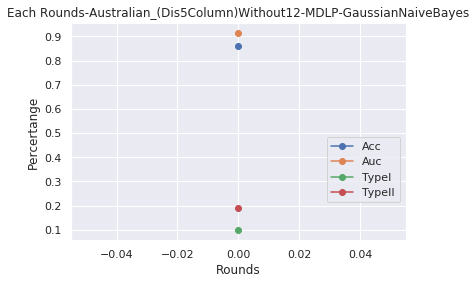

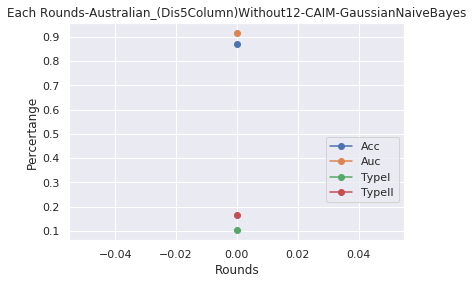

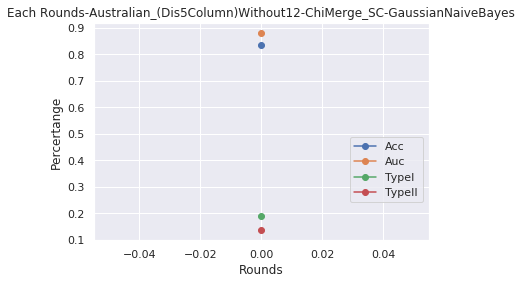

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.79 0.90   0.09    0.37          0.54
MDLP          0.86 0.91   0.10    0.19          7.33
CAIM          0.87 0.92   0.10    0.17         16.35
ChiMerge      0.83 0.88   0.19    0.14        108.97


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Mean Accuracy: 0.5855072463768116
Mean Accuracy[0.6014492753623188, 0.5869565217391305, 0.5797101449275363, 0.6231884057971014, 0.5362318840579711]
Mean Auc: 0.6264301659867024
Mean Auc[0.5999564459930314, 0.687181663837012, 0.6468362413285684, 0.6472807991120977, 0.550895679662803]
Mean TypeII: 0.7982949261654481
Mean TypeII[0.7857142857142857, 0.7903225806451613, 0.7887323943661971, 0.8113207547169812, 0.8153846153846154]
Mean TypeI: 0.1051655060149668
Mean TypeI[0.13414634146341464, 0.10526315789473684, 0.029850746268656716, 0.10588235294117647, 0.1506849315068493]


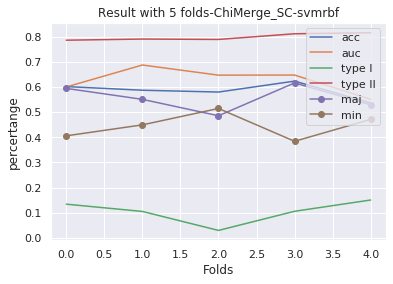

Compare Result-Australian_(Dis5Column)Without12-svmrbf


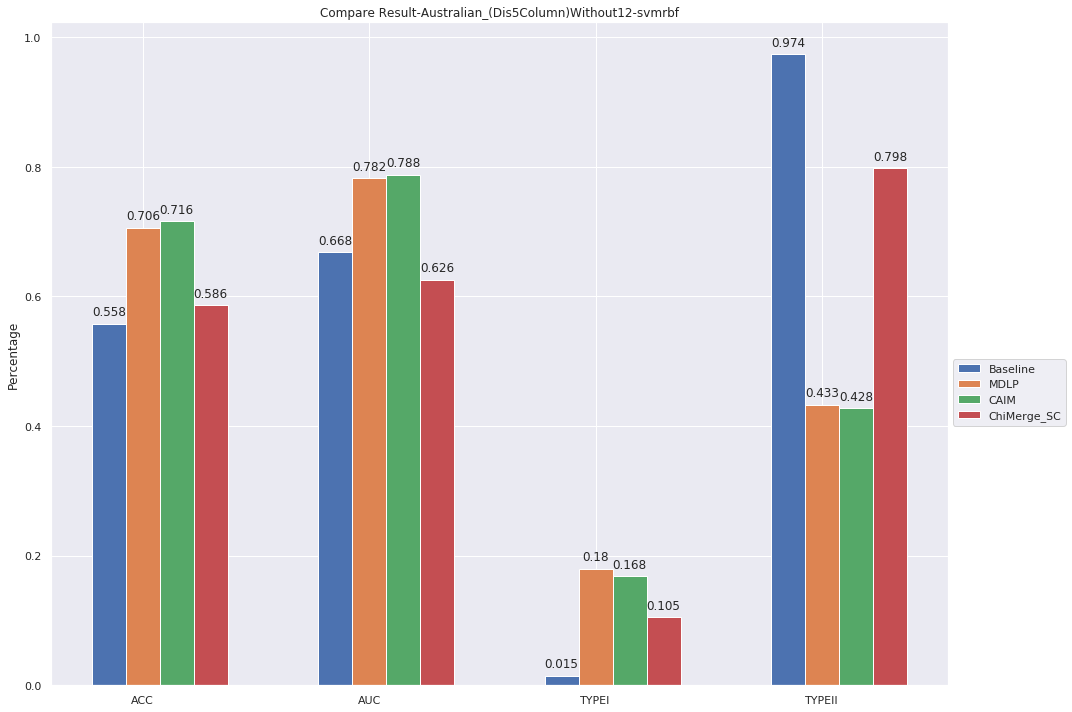

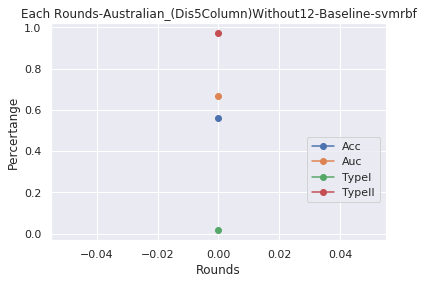

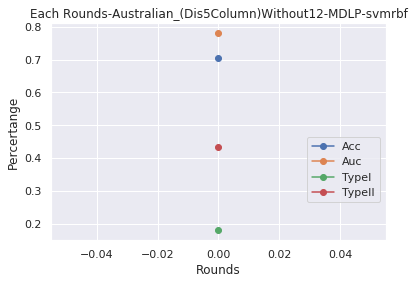

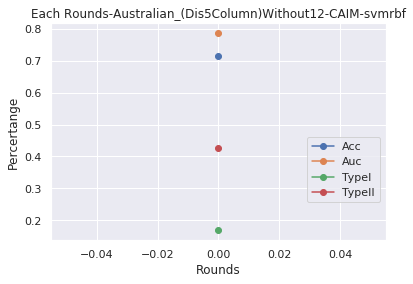

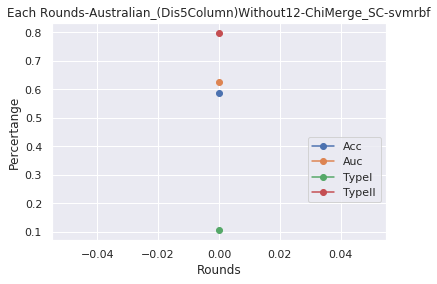

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.56 0.67   0.01    0.97          2.40
MDLP          0.71 0.78   0.18    0.43          8.27
CAIM          0.72 0.79   0.17    0.43         16.98
ChiMerge      0.59 0.63   0.11    0.80        107.82


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Mean Accuracy: 0.8536231884057971
Mean Accuracy[0.8405797101449275, 0.8623188405797102, 0.8623188405797102, 0.8405797101449275, 0.8623188405797102]
Mean Auc: 0.9010334097665368
Mean Auc[0.8828240252897787, 0.906986531986532, 0.9205128205128205, 0.8980200127741111, 0.8968236582694415]
Mean TypeII: 0.10377393098704575
Mean TypeII[0.1076923076923077, 0.12121212121212122, 0.03333333333333333, 0.14754098360655737, 0.10909090909090909]
Mean TypeI: 0.18033272452731106
Mean TypeI[0.2054794520547945, 0.1527777777777778, 0.21794871794871795, 0.16883116883116883, 0.1566265060240964]
Mean Accuracy: 0.8536231884057971
Mean Accuracy[0.8623188405797102, 0.8768115942028986, 0.8405797101449275, 0.8260869565217391, 0.8623188405797102]
Mean Auc: 0.9045981421777926
Mean Auc[0.8951941643424157, 0.9523504273504274, 0.9122677364864864, 0.8808065878378379, 0.8823717948717948]
Mean TypeII: 0.18138064971751414
Mean TypeII[0.1016949152542373, 0.21666666666666667, 0.203125, 0.21875, 0.16666666666666666]
Mean Type

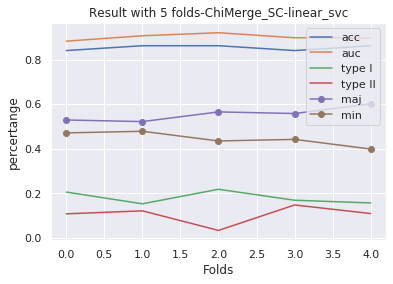

Mean Accuracy: 0.8405797101449275
Mean Accuracy[0.8188405797101449, 0.8840579710144928, 0.8478260869565217, 0.8405797101449275, 0.8115942028985508]
Mean Auc: 0.8906358207576464
Mean Auc[0.8450976185367948, 0.9311868686868687, 0.8735109378384232, 0.9085470085470085, 0.894836670179136]
Mean TypeII: 0.15087162020257472
Mean TypeII[0.15254237288135594, 0.13636363636363635, 0.05263157894736842, 0.16666666666666666, 0.24615384615384617]
Mean TypeI: 0.1625617090460163
Mean TypeI[0.20253164556962025, 0.09722222222222222, 0.2222222222222222, 0.15384615384615385, 0.136986301369863]


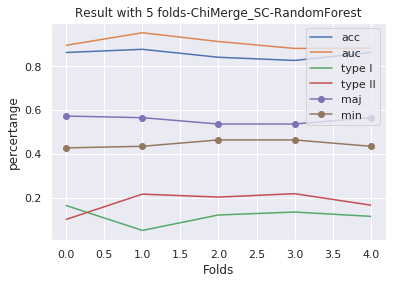

Compare Result-Australian_(Dis5Column)Without12-linear_svc


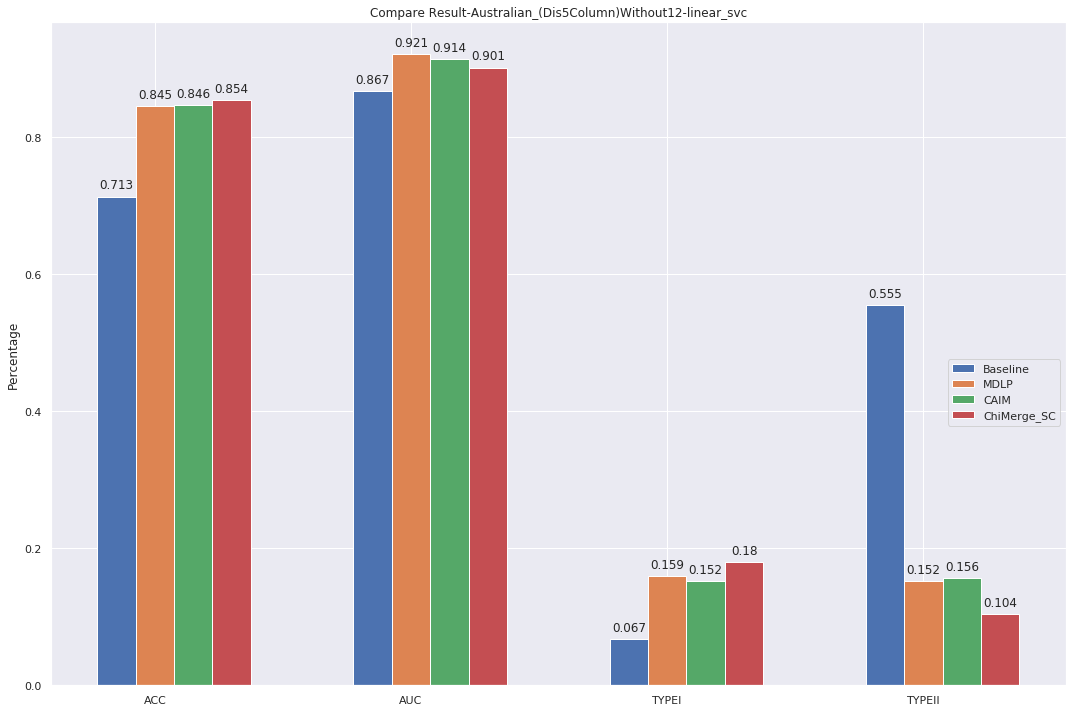

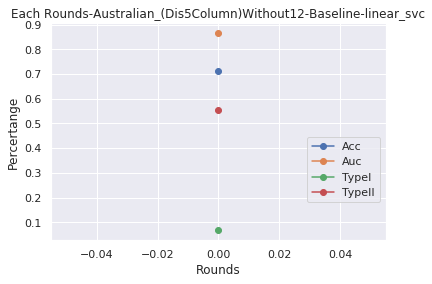

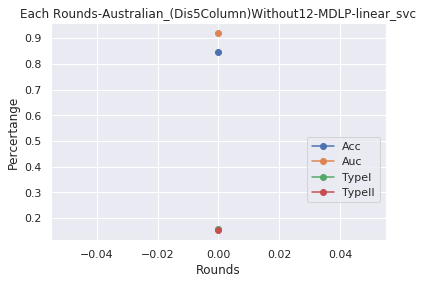

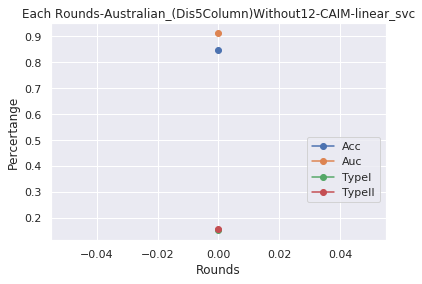

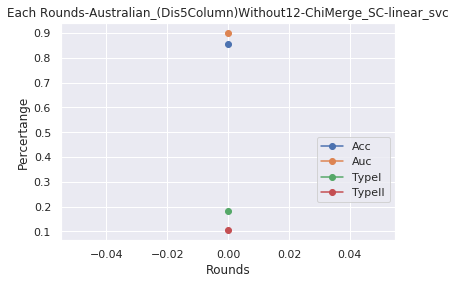

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.71 0.87   0.07    0.56          6.04
MDLP          0.84 0.92   0.16    0.15          8.37
CAIM          0.85 0.91   0.15    0.16         19.33
ChiMerge      0.85 0.90   0.18    0.10        105.02


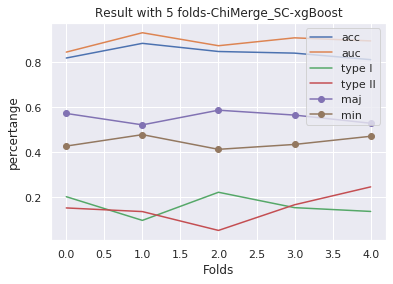

Compare Result-Australian_(Dis5Column)Without12-RandomForest


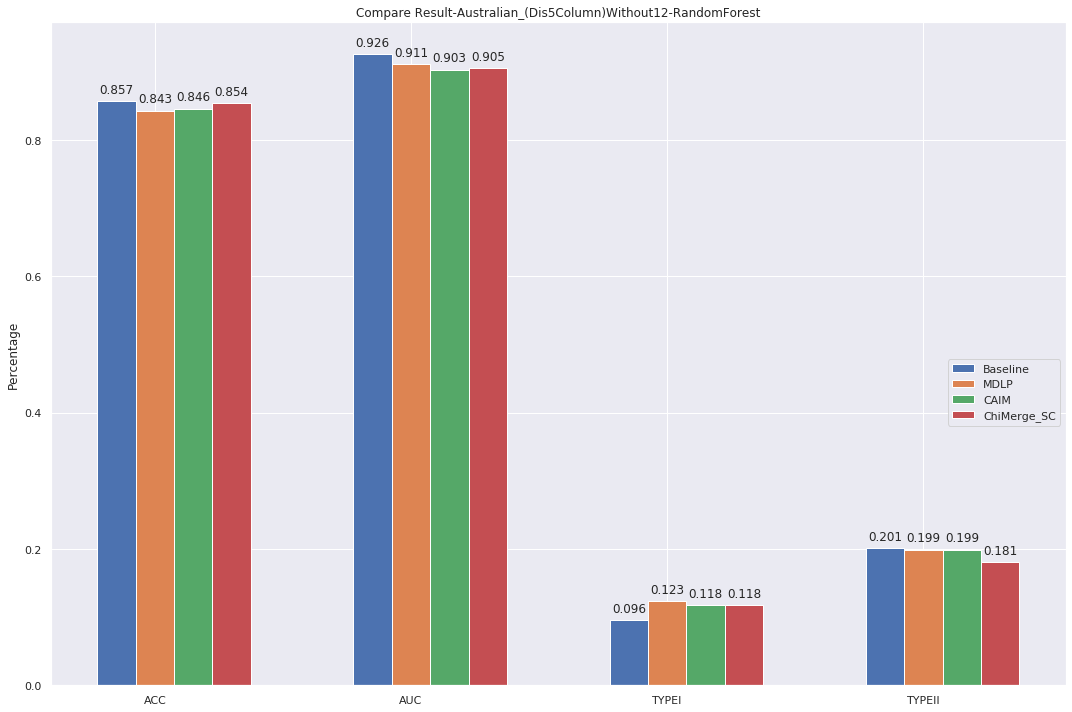

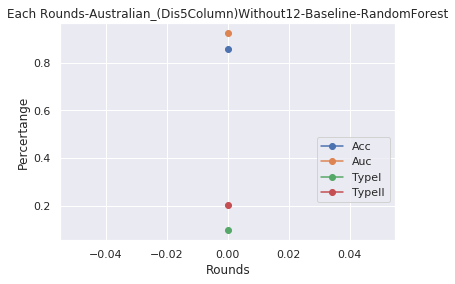

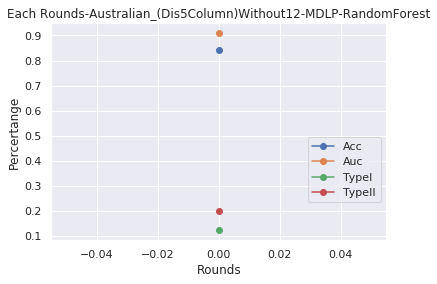

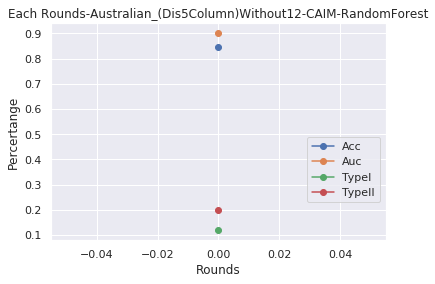

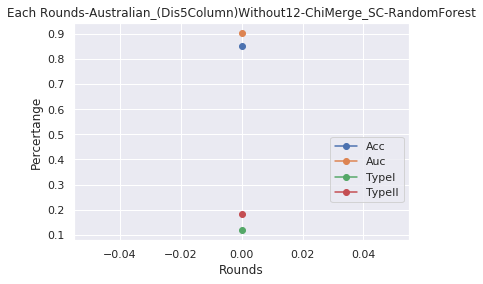

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.86 0.93   0.10    0.20          4.92
MDLP          0.84 0.91   0.12    0.20          8.44
CAIM          0.85 0.90   0.12    0.20         17.56
ChiMerge      0.85 0.90   0.12    0.18        108.08
Compare Result-Australian_(Dis5Column)Without12-xgBoost


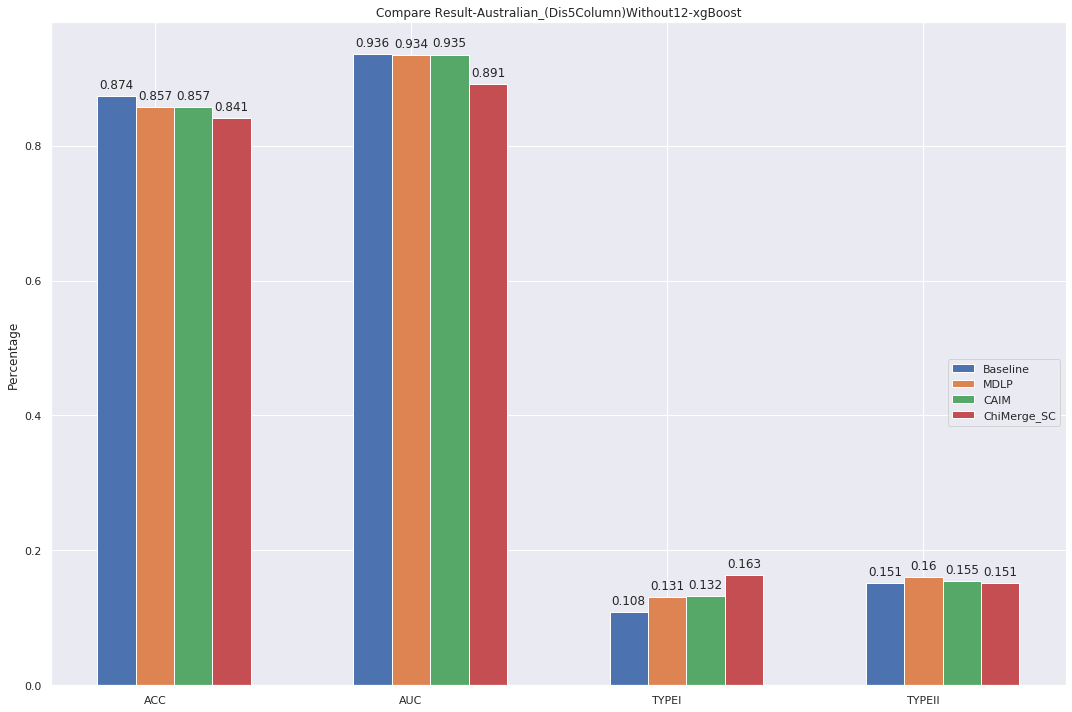

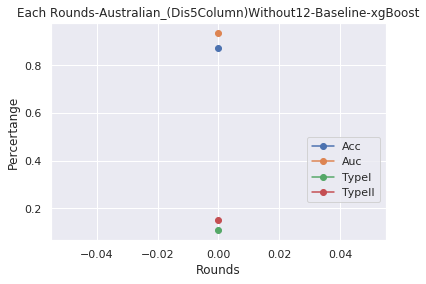

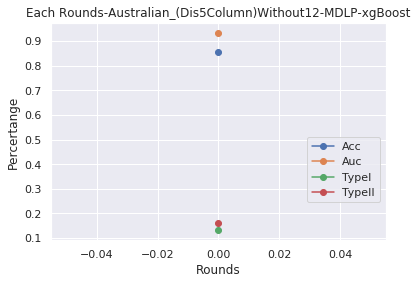

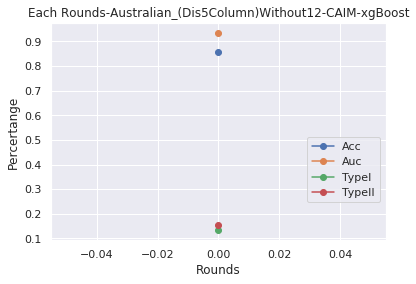

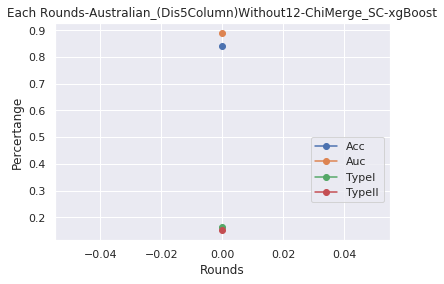

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.87 0.94   0.11    0.15          3.21
MDLP          0.86 0.93   0.13    0.16          8.64
CAIM          0.86 0.94   0.13    0.16         17.20
ChiMerge      0.84 0.89   0.16    0.15        111.60


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Mean Accuracy: 0.8304347826086957
Mean Accuracy[0.8260869565217391, 0.8043478260869565, 0.8840579710144928, 0.8260869565217391, 0.8115942028985508]
Mean Auc: 0.8919092566504293
Mean Auc[0.891528274122346, 0.8665522420081527, 0.9138655462184875, 0.9120370370370371, 0.8755631838661231]
Mean TypeII: 0.1529411489136791
Mean TypeII[0.13432835820895522, 0.1694915254237288, 0.16176470588235295, 0.12962962962962962, 0.1694915254237288]
Mean TypeI: 0.18055972968613365
Mean TypeI[0.2112676056338028, 0.21518987341772153, 0.07142857142857142, 0.20238095238095238, 0.20253164556962025]


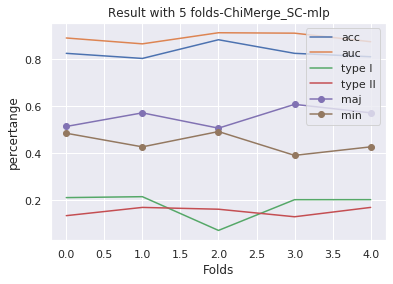

Compare Result-Australian_(Dis5Column)Without12-mlp


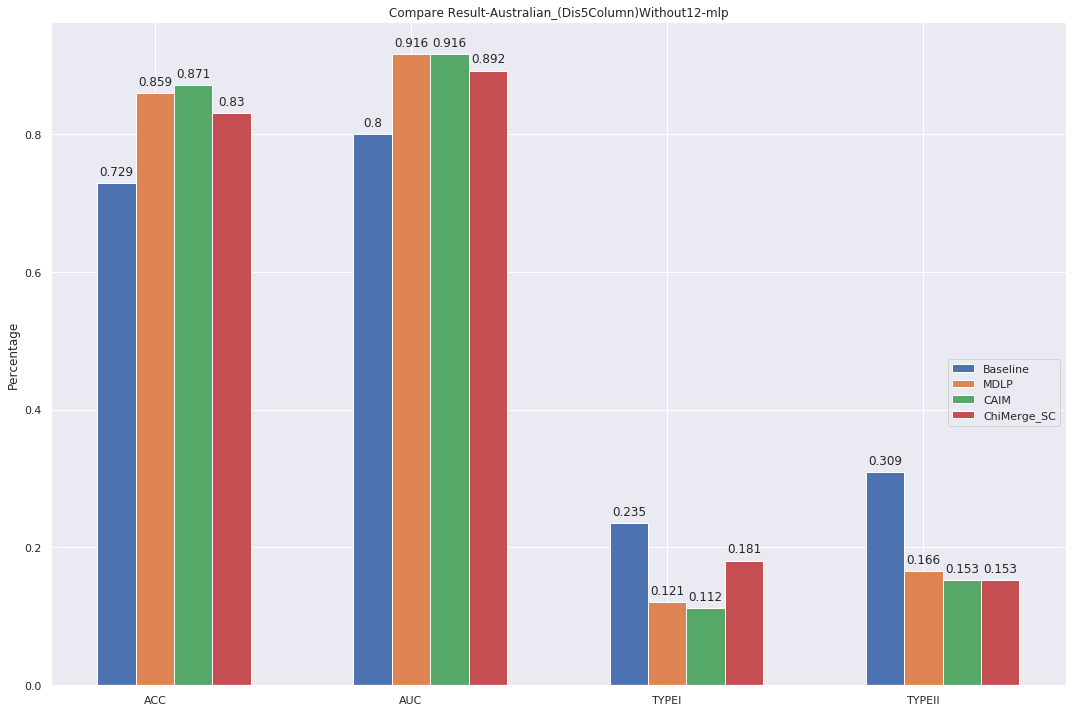

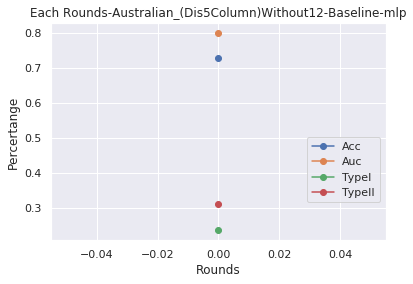

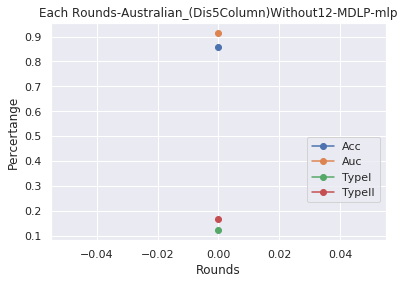

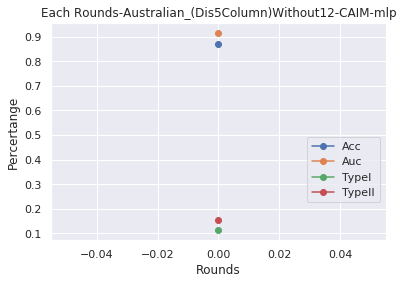

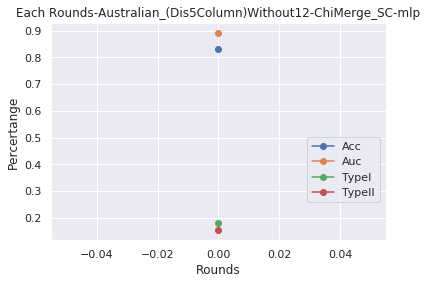

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.73 0.80   0.23    0.31         12.92
MDLP          0.86 0.92   0.12    0.17         20.04
CAIM          0.87 0.92   0.11    0.15         41.98
ChiMerge      0.83 0.89   0.18    0.15         71.42

程式結束
Wall time: 2min 27s


In [10]:
%%time

# Classifcation Method
linear_svc = CalibratedClassifierCV(LinearSVC(max_iter=7000))
svmlinear = SVC(kernel='linear', probability=True)
svmrbf = SVC(kernel='rbf', probability=True)
DecisionTreeClassifier = tree.DecisionTreeClassifier()
RandomForest = RandomForestClassifier()
logisticRegression = LogisticRegression()
mlp = MLPClassifier()
xgBoost = xgb.XGBClassifier()
GaussianNaiveBayes = GaussianNB()


##########################################
#svmpoly = SVC(kernel='poly', probability=True)
#neigh = KNeighborsRegressor(n_neighbors=5)
#linearRegression= LinearRegression()

#DecisionTreeClassifier,logisticRegression,mlp,xgBoost
# classifier_list = [svmrbf,DecisionTreeClassifier,RandomForest,logisticRegression,mlp,xgBoost ]
# classifier_name_list = ['svmrbf','DecisionTreeClassifier','RandomForest','LogisticRegression','MLPClassifier','xgBoost' ]
def run10times(classifier_list,classifier_name_list):

    classifier_list = [classifier_list]
    classifier_name_list = [classifier_name_list]
        
    classifier_result_list = []



    for idx,classifi in enumerate(classifier_list):

        result_list = []
        rounds = 2
        clf_name = classifier_name_list[idx]
        for i in range(1,rounds):

            result_list.clear()
            result_10times_baseline = []
            result_10times_MDLP = []
            result_10times_CAIM = []
            result_10times_ChiMerge_SC = []
            result_10times_ChiMerge_RG = []
            runnung_time_list = []
            #Method Select

            clf = classifi
            fold = 5

            start_time = time.time()
            result_eachtimes_baseline = KFoldFuntion(clf, clf_name, 'Baseline', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_baseline.append(result_eachtimes_baseline)
            print("Mean : {0}".format(np.mean(result_10times_baseline, axis=0)))
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_MDLP = KFoldFuntion(clf, clf_name, 'MDLP', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_MDLP.append(result_eachtimes_MDLP)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_CAIM = KFoldFuntion(clf, clf_name, 'CAIMD', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_CAIM.append(result_eachtimes_CAIM)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_ChiMerge_SC = KFoldFuntion(clf, clf_name, 'ChiMerge_SC', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_ChiMerge_SC.append(result_eachtimes_ChiMerge_SC)
            runnung_time_list.append(time.time() - start_time)
    
        
        # Thread Lock
        lock.acquire()
        
        
        # Compare Chart (Same Classifier)
        CompareMethodMeanResult(data_name, clf_name, rounds,result_10times_baseline,result_10times_MDLP,result_10times_CAIM,result_10times_ChiMerge_SC)


        # Compare Chart (Same Classifier)
        ResultEachMethodLineChart(result_10times_baseline,"Baseline",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_MDLP,"MDLP",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_CAIM,"CAIM",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_ChiMerge_SC,"ChiMerge_SC",data_name,clf_name)

        result_list.append(np.mean(result_10times_baseline, axis=0))
        result_list.append(np.mean(result_10times_MDLP, axis=0))
        result_list.append(np.mean(result_10times_CAIM, axis=0))
        result_list.append(np.mean(result_10times_ChiMerge_SC, axis=0))

        # Single Classify Method 
        result_with_method = pd.DataFrame(result_list, index=['Baseline','MDLP','CAIM','ChiMerge'], columns=['Accuracy','AUC','TypeI','TypeII'])
        result_with_method['Time(Second)'] = runnung_time_list
        print(result_with_method)

        file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
        file_name = "Classifier_result_list_{fold}Fold_{data_name}_{method}_{file_timeA}.xlsx".format(fold = fold, file_timeA = file_time,data_name=data_name,method=clf_name)
        pd.DataFrame(result_with_method).to_excel("resultsexcel/"+file_name)
        
        
        # Thread Unlock
        lock.release()
    


t0 = Thread(target=run10times,args=(svmlinear,"svmlinear"))
t1 = Thread(target=run10times,args=(linear_svc,"linear_svc"))
t2 = Thread(target=run10times,args=(svmrbf,"svmrbf"))
t3 = Thread(target=run10times,args=(DecisionTreeClassifier,"DecisionTreeClassifier"))
t4 = Thread(target=run10times,args=(RandomForest,"RandomForest"))
t5 = Thread(target=run10times,args=(logisticRegression,"logisticRegression"))
t6 = Thread(target=run10times,args=(mlp,"mlp"))
t7 = Thread(target=run10times,args=(xgBoost,"xgBoost"))
t8 = Thread(target=run10times,args=(GaussianNaiveBayes,"GaussianNaiveBayes"))


thread_list = [t1,t2,t3,t4,t5,t6,t7,t8]
#thread_list = [t4]

#程式開始
for item in thread_list:
    item.start()
print("\n程式開始")


#程式結束
for item in thread_list:
    item.join()
print("\n程式結束")
    


#############################################################################YEE

## Record Result

title = 'Compare Result-{data_name}-{classifier_name}'.format(data_name=data_name,classifier_name=clf_name)
with pd.ExcelWriter('output.xlsx') as writer:  # doctest: +SKIP
        df1.to_excel(writer, sheet_name='Sheet_name_1')
        df2.to_excel(writer, sheet_name='Sheet_name_2')

file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
file_name = "result_10times_baseline_{file_timeA}.xlsx".format(file_timeA = file_time)
pd.DataFrame(result_10times_baseline).to_excel(file_name, header=False, index=False)

## Compare result

print("Mean : {0}".format(np.mean(result_10times_baseline, axis=0))) 

print("Mean : {0}".format(np.mean(result_10times_MDLP, axis=0))) 

print("Mean : {0}".format(np.mean(result_10times_CAIM, axis=0)))

print("Mean : {0}".format(np.mean(result_10times_ChiMerge_SC, axis=0)))

In [11]:

#ResultEachMethodLineChart(result_10times_ChiMerge_RG,"ChiMerge_RG",data_name,clf_name)